##### Esboço para a criação de funções de risco 


 Futuramente esse arquivo irá mudar para .py e sera um "pacote" interno de funções de risco 



##### Individuais

Funções : 


- Stress 3D Descorr; (falta)
- Parametric VaR 95%; (falta)
>- HistoricalStress 3D Corr;   
>- Historical VaR (95%);
>- Historical Conditional VaR (95%);
>- Drawdown Probability;
>- Max Drawdown
- Historical Quote (BackTest); (falta)
>- Sharp Index;
>- Sortino Index;
>- Information Ratio;
>- Omega Ratio;
>- Calmar Ratio;


Gráficos: 

>- Omega ratio view 
>- Return distribuition



##### Comparativos



Gráficos: 

>- Return distribuition (violinplot)




In [56]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
import warnings
import yfinance as yf



########################################## Dados utilizados para a construção das funções 
# Obtenha os dados do índice IBOVESPA

df = yf.Ticker("GGBR4.SA").history(start="2000-01-01")
df['Close_yesterday'] = df['Close'].shift(1)
df['OvernightStrategy'] =  df['Open'] / df['Close_yesterday'] - 1
df['NormalStrategy'] = df['Close'] / df['Close_yesterday'] - 1
df['UnderdayStrategy'] = df['Close'] / df['Open'] - 1
df.fillna(0,inplace=True)
df = df[1:-1]

strategies = df[['NormalStrategy','OvernightStrategy','UnderdayStrategy']]
strategies = (strategies+1).cumprod()[-2500:]

serie_x = strategies['OvernightStrategy']
serie_y = strategies['NormalStrategy']
serie_z = strategies['UnderdayStrategy']



In [10]:
### Historical Stress Correlate
##### input: pandas time series or numpy array ; consecutive days 
##### output: tuple with (Stress, stress date)

def historical_stress_correlate(data, consecutive):
    ''' Historical Stress Correlate: Worse case scenario in the past with m consecutive days; one portfolio'''


    n_day_returns = (data+1).rolling(window = consecutive).apply(np.prod) - 1
    n_day_returns = n_day_returns.sort_values(ascending = True)

    stress = n_day_returns[0]
    stress_date = n_day_returns.index[0]
    return (stress, stress_date)



In [21]:
### Historical VaR Correlated
### input: pandas time series of returns; consecutive days ; confidence level 
### output: historical VaR correlated 

def historical_var_correlated(returns, consecutive = 1, confidence_level = 0.95):
    ''' Historical VaR Correlated: Percentile of the return of the portfolio'''

    n_days_return = (data+1).rolling(window = consecutive).apply(np.prod) - 1
    n_days_return = n_days_return.dropna()

    var = n_days_return.quantile(1-confidence_level)
    var_date = n_days_return[n_days_return <= var].index[-1]

    return var


In [20]:
### Historical conditional VaR
### input: pandas time series of returns; confidence level
### output: Conditional VaR calculated using historical method

def historical_conditional_var(returns, confidence_level):
    # Sort returns from smallest to largest
    sorted_returns = sorted(returns)
    
    # Calculate the index associated with the confidence level
    confidence_index = int(confidence_level * len(sorted_returns))
    
    # Calculate the corresponding return, VaR and CVaR
    var = sorted_returns[confidence_index]
    cvar = returns[returns <= var].mean()
    
    return cvar


Date
2017-05-08      5.655334
2017-05-09      5.723026
2017-05-10      5.818708
2017-05-11      5.836501
2017-05-12      5.889188
                 ...    
2023-07-26    132.092888
2023-07-27    131.410827
2023-07-28    131.180123
2023-07-31    131.734800
2023-08-01    130.834046
Name: OvernightStrategy, Length: 1555, dtype: float64

In [ ]:
### Drawdown Probability
### Input: pandas time series of daily returns ; dd limit
### Output: probability of drawdown greater than dd limit

def drawdown_prob(returns, target):
    drawdowns = drawdown(returns)
    prob_dd = len(drawdowns[drawdowns < target]) / len(drawdowns)
    return prob_dd


In [ ]:
### Max Drawdown
## input: pandas time series of daily returns
## output: max drawdown, max drawdown duration

def max_drawdown(returns):
    # We need to calculate a wealth index
    wealth_index = 1000*(1+returns).cumprod()
    # Then we can calculate previous peaks
    previous_peaks = wealth_index.cummax()
    # Then we can calculate drawdowns
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return drawdown.min(), drawdown.idxmin()

    

In [ ]:
### Sharp ratio

def sharpe_ratio(returns, rf_rate, periods_per_year):
    sharp = (returns - rf_rate) / returns.std() * np.sqrt(periods_per_year)
    return sharp


In [22]:
### Sortino Ratio

def sortino_ratio(returns, rf=0, target=0):
    """
    Calculates the Sortino Ratio of a returns stream based on a target
    return and a risk free rate.
    Parameters:
    returns - A pandas Series representing period percentage returns.
    rf - A float representing the risk free rate over the period. 
         Default is 0
    target - A float representing the minimum acceptable return.
             Default is 0
    Returns:
    A float representing the Sortino Ratio of the returns stream
    """
    downside_diff = returns.copy()
    downside_diff.loc[returns < target] = (returns - target) ** 2
    expected_return = returns.mean() * 252
    downside_deviation = np.sqrt(downside_diff.sum() * 252)
    return (expected_return - rf) / downside_deviation

In [ ]:
# Information ratio 

def information_ratio(returns, factor_returns):
    """
    Determines the information ratio of a strategy
    based on the returns of that strategy and the returns of a benchmark.

    Parameters
    ----------
    returns : DataFrame
        Returns for each day for the strategy, noncumulative.
    factor_returns : DataFrame
        Returns for each day for the benchmark, noncumulative.

    Returns
    -------
    float
        Information ratio.
    """
    return_difference = returns - factor_returns
    volatility = return_difference.std(ddof=1)
    return np.mean(return_difference) / volatility

In [ ]:
# Omega ratio

def omega_ratio(returns, risk_free_rate=0.0, required_return=0.0):
    '''
    Omega ratio
    https://www.wallstreetmojo.com/omega-ratio/#h-the-formula-of-omega-ratio
    
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
    risk_free_rate : float, optional
        Constant risk-free return throughout the period.
    required_return : float, optional
        Minimum acceptable return threshold.

    Returns
    -------
    float
        Omega ratio.
    '''
    gain_days = returns[returns >= required_return].sum()
    loss_days = returns[returns < required_return].sum()

    omega = gain_days / -loss_days

    return omega



In [ ]:
# Calmar ratio

def calmar_ratio(returns):
    '''
    Calmar ratio 
    a measure of risk-adjusted return based on maximum drawdown.

    Parameters
    ----------
    returns : pandas.Series
        Daily returns of the strategy, noncumulative.

    Returns
    -------
    float
        Calmar ratio
    '''
    cumulative_returns = returns.cumsum().dropna()
    max_drawdown = max_drawdown(cumulative_returns)[0]
    
    return cumulative_returns.iloc[-1] / abs(max_drawdown)


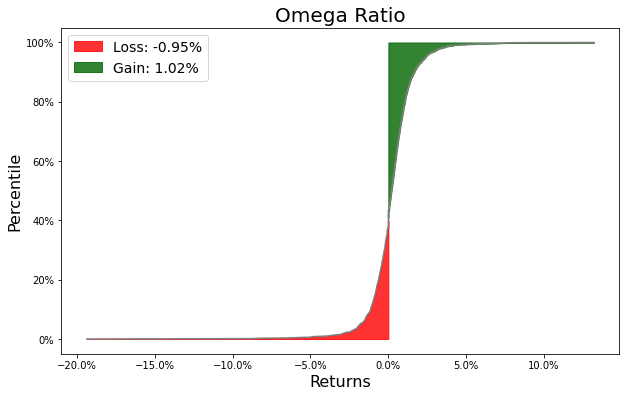

In [67]:
# Plot omega ratio view


def omega_ratio_view(returns, target=0):
    
    #Get percentile of returns
    returns = returns.sort_values(ascending=True).dropna()

    pct = returns.sort_values(ascending=True).rank(pct=True).dropna()
    pct.name = 'pct'

    avg_gain = returns[returns>target].mean()
    avg_loss = returns[returns<target].mean()

    fig, ax = plt.subplots(figsize=(10, 6))

    sns.lineplot(y=pct, x=returns, color='grey', ax=ax)


    # If left from target color red
    ax.fill_betweenx(pct,target, returns, where=returns<target, color='red', alpha=0.8, label=f'Loss: {avg_loss*100:.2f}%')

    # If right from target color green
    ax.fill_betweenx(pct,target, returns, where=returns>target, color='darkgreen', alpha=0.8, label=f'Gain: {avg_gain*100:.2f}%')

    ax.set_title('Omega Ratio', fontsize=20)
    ax.set_xlabel('Returns', fontsize=16)
    ax.set_ylabel('Percentile', fontsize=16)
    #labels in % format
    mtick = ticker
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.legend(fontsize=14)

omega_ratio_view(serie_x.pct_change().dropna())

C:\Users\diogo\AppData\Local\Temp\ipykernel_2980\1242699614.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in mticks])


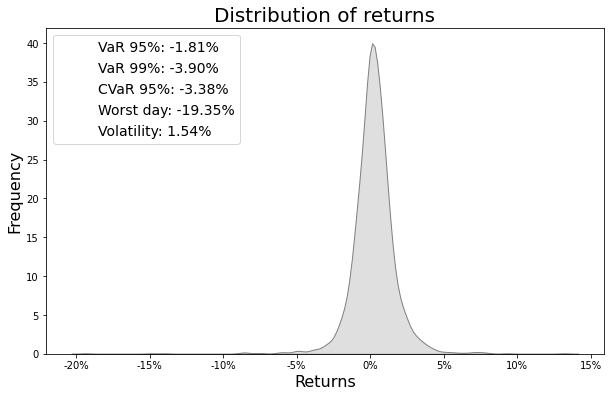

In [118]:
### Plot returns distributions


def return_distribution(returns, annot = True):



    fig, ax = plt.subplots(figsize=(10, 6))


    sns.kdeplot(returns,color = 'grey',shade=True, ax=ax)

    ax.set_title('Distribution of returns', fontsize=20)
    ax.set_xlabel('Returns', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    


    mticks = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in mticks])

    if annot:
        
        var95 = returns.quantile(0.05)
        var99 = returns.quantile(0.01)
        cvar95 = returns[returns <= var95].mean()   
        worst_day = returns.min()
        volatility = returns.std()
        
        # Insere os dados no gráfico através de linhas verticais até a curva
        ax.axvline(var95, color='yellow', linestyle='--', lw=.1, alpha=0, label=f'VaR 95%: {var95:.2%}')
        ax.axvline(var99, color='orange', linestyle='--', lw=.1, alpha=0, label=f'VaR 99%: {var99:.2%}')
        ax.axvline(cvar95, color='red', linestyle='--', lw=.1, alpha=0, label=f'CVaR 95%: {cvar95:.2%}')
        ax.axvline(worst_day, color='darkred', linestyle='--', lw=.1, alpha=0, label=f'Worst day: {worst_day:.2%}')
        ax.axvline(volatility, color='green', linestyle='--', lw=.1, alpha=0, label=f'Volatility: {volatility:.2%}')
        
        ax.legend(fontsize=14, loc='upper left')

    

    
return_distribution(serie_x.pct_change().dropna())

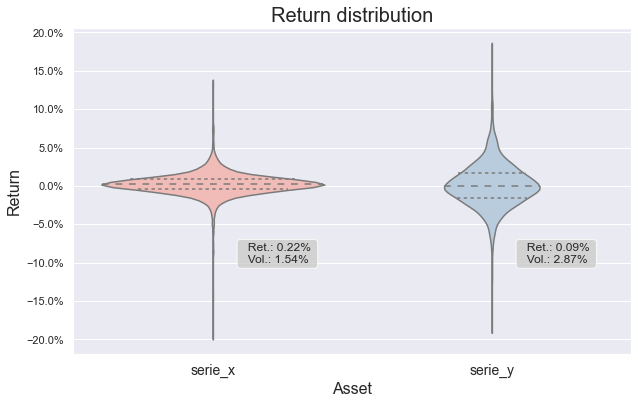

In [189]:
### Violin plots
sns.set(style="darkgrid")

def violin_plot(lista_series,lista_names,annot=True):
        
    bbox = dict(boxstyle="round", fc="0.8", alpha=0.8)

    # Series list to dataframe
    lista_series = pd.concat(lista_series,axis=1)
    lista_series.columns = lista_names

    #sns violinplot

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(data=lista_series,ax=ax,inner="quartile",palette="Pastel1")
    ax.set_title("Return distribution", fontsize=20)
    ax.set_ylabel("Return", fontsize=16)
    ax.set_xlabel("Asset", fontsize=16)
    ax.set_xticklabels(lista_series.columns, fontsize=14)
    # y tick in percentage 
    mtick = ticker
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


    if annot:
        # Retornos e vol de cada ativo
        for i,name in enumerate(lista_names):
            retorno_i = lista_series[name].mean()
            vol_i = lista_series[name].std()
            ax.annotate('  Ret.: {:,.2%} \n  Vol.: {:,.2%}'.format(retorno_i,vol_i)
                        , xy=(i, 0)
                        , xytext=(i+0.1, -.1)
                        , bbox=bbox
                        )


    

violin_plot([serie_x.pct_change().dropna(),serie_y.pct_change().dropna()], ["serie_x","serie_y"])